In [1]:
from pytorch_lightning import callbacks
import yaml
import argparse
import numpy as np
import cv2
import matplotlib.pyplot as plt 
from models import *
from experiments.vae_experiment import VAEXperiment
from experiments.vae_pix2pix_exp import Pix2pixExperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TestTubeLogger
from torch.utils.data import DataLoader 
from terrain_loader import TerrainDataset
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:

with open("configs/vae_pix2pix.yml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(".\n\n",exc)

In [3]:
dataset = TerrainDataset(root = config['exp_params']['data_path'],
                        train=False,
                        hide_green=config['exp_params']['hide_green'],
                        norm=config['exp_params']['norm'])

sample_dataloader = DataLoader(dataset,
                        batch_size= 1,
                        num_workers=config['exp_params']['n_workers'],
                        shuffle = True,
                        drop_last=False)

In [4]:
#Vae Model
vae_model = vae_models[config['vae_model_params']['name']](**config['vae_model_params'])

# pix2pix model
gen_model = pix2pix_model[config['pix2pix_model_params']['gen_name']](config['exp_params']['in_channels'],config['exp_params']['out_channels'])
disc_model = pix2pix_model[config['pix2pix_model_params']['disc_name']](config['exp_params']['in_channels'])


In [ ]:
# VAE-FeatureGAN 1
! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VanillaVAE/version_0  /scratch/shan/
! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VAE_PIX2PIX/version_3 /scratch/shan

In [5]:
if config['vae_model_params']['load_model'] :
    experiment_p2p = Pix2pixExperiment.load_from_checkpoint(config['pix2pix_model_params']['pretrained_model'], gen_model=gen_model,disc_model=disc_model,vae_model=vae_model,params=config['exp_params'])
    experiment_vae = VAEXperiment.load_from_checkpoint(config['vae_model_params']['pretrained_model'], vae_model=vae_model,params=config['exp_params'])
    print("[INFO] Loaded pretrained model")

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/shan/version_3/checkpoints/epoch=499-step=46499.ckpt'

In [6]:
vae_model.eval()
gen_model.eval()

Generator(
  (down1): DownSample(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down2): DownSample(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down3): DownSample(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down4): DownSample(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

In [7]:
def denormalize(result):
        # minv, maxv = torch.min(result), torch.max(result)
        new = (result+1)*127.5
        return torch.squeeze(new).detach().numpy().transpose((1,2,0)).astype(np.uint8)


In [8]:
def display(ip, op, val=0):
    res = vae_model(ip)[0] 
    vae_res = torch.squeeze(res*255).detach().numpy().transpose((1,2,0)).astype(np.uint8)
    # res = res*2-1

    res = gen_model(res) 
    res = denormalize(res)
    op = denormalize(op)
    # ip = denormalize(ip)
    ip = (ip*255)
    ip = torch.squeeze(ip).detach().numpy().transpose((1,2,0)).astype(np.uint8)
    res = cv2.GaussianBlur(res, (5, 5), 0)
    
    print(ip.shape, op.shape,res.shape,vae_res.shape)
    display_list = [ip,vae_res,res,op]
    title = ['Input image','VAE Input','Predicted_image','Ground_Truth']

    plt.figure(figsize=(15,15))

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i],cmap='gray')
        plt.axis('off')
        cv2.imwrite("disp_"+str(val)+"_"+str(i+1)+".png",display_list[i])
    plt.show()



(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


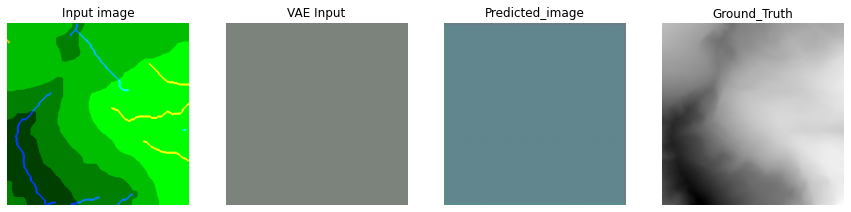

In [9]:
for ip, op in sample_dataloader:
    display(ip,op)
    
    break

In [10]:
def display_multiple(ip, op ):
    display(ip,op)
    plt.figure(figsize=(20,10))

    mu,var = vae_model.encode(ip)

    for i in range(5):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        z = eps * std + mu
        res = vae_model.decode(z)
        vae_res = torch.squeeze(res*255).detach().numpy().transpose((1,2,0)).astype(np.uint8)

        # res = res*2-1
        res = gen_model(res) 
        res = denormalize(res)

        plt.subplot(2, 5, i+1) 
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(vae_res,cmap='gray')
        plt.axis('off')
        cv2.imwrite("vae_ot_"+str(i+1)+".png",vae_res)

        plt.subplot(2, 5, i+6) 
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(res,cmap='gray')
        plt.axis('off')
        res = cv2.GaussianBlur(res, (5, 5), 0)
        cv2.imwrite("res_"+str(i+1)+".png",res)



    plt.show()

 



(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


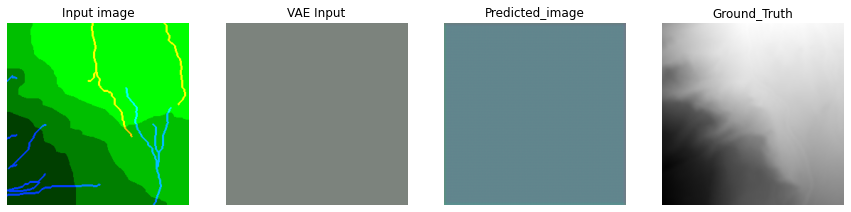

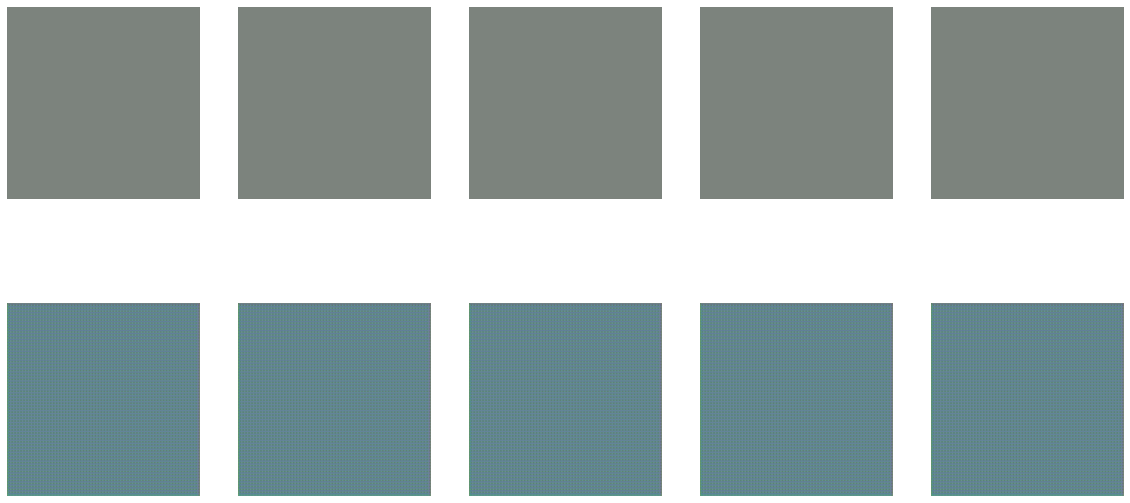

In [11]:
for ip, op in sample_dataloader:
    display_multiple(ip,op)
    
    break

In [12]:
def display_interpolation(ip1,op1,ip2,op2):
    display(ip1,op1,1)
    display(ip2,op2,2)

    plt.figure(figsize=(20,10))

    mu1,var1 = vae_model.encode(ip1)
    mu2,var2 = vae_model.encode(ip2)

    # for i in range(4):
    ratios = np.linspace(0, 1, num=8)
    vectors = []

    for ratio in ratios:
        v = (1.0 - ratio) * mu1 + ratio * mu2
        vectors.append(v)

    images = [] 

    for j,v in enumerate(vectors):
       logits = vae_model.decode(v)
       images.append(logits)
    print(len(images))

    for i,j in enumerate(images):
        vae_res = torch.squeeze(j*255).detach().numpy().transpose((1,2,0)).astype(np.uint8)

        # res = res*2-1
        res=j
        res = gen_model(res) 
        res = denormalize(res)

        plt.subplot(2, 8, i+1) 
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(vae_res,cmap='gray')
        plt.axis('off')
        cv2.imwrite("int_vae_"+str(i+1)+".png",vae_res)

        plt.subplot(2, 8, i+9) 
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(res,cmap='gray')
        plt.axis('off')
        res = cv2.GaussianBlur(res, (5, 5), 0)
        cv2.imwrite("int_res_"+str(i+1)+".png",res)



    plt.show()






    

(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


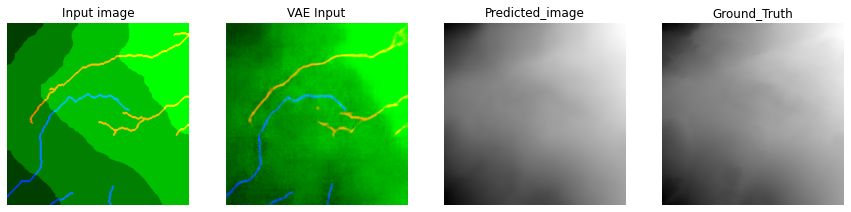

(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


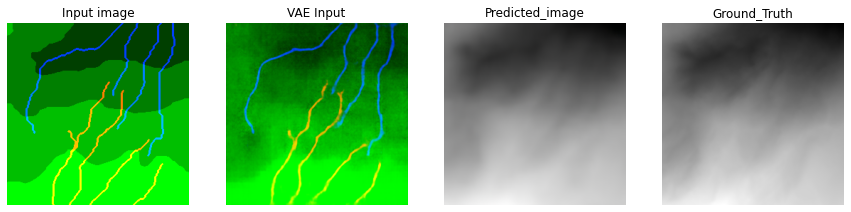

8


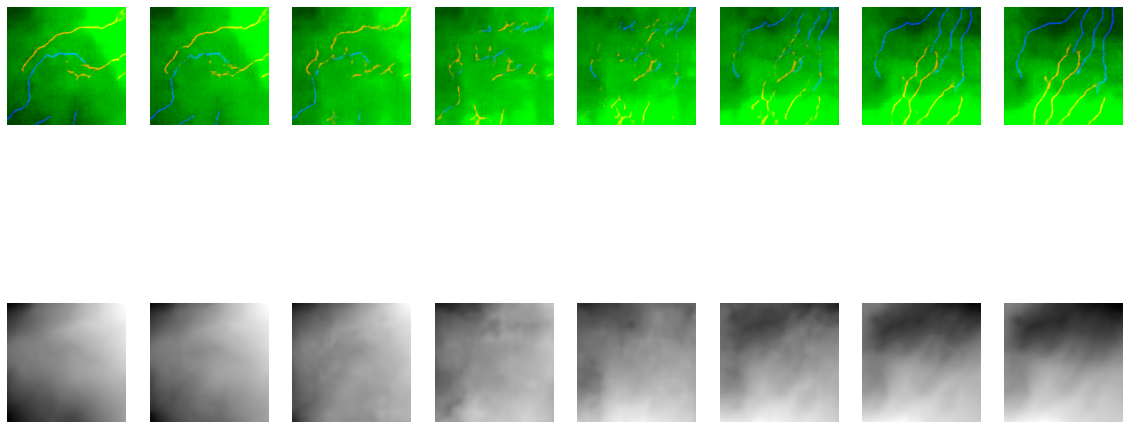

In [54]:
sample_dataloader_2 = DataLoader(dataset,
                        batch_size= 2,
                        num_workers=config['exp_params']['n_workers'],
                        shuffle = True,
                        drop_last=False)

for ip, op in sample_dataloader_2:
    ip1 = torch.unsqueeze(ip[0], 0)
    ip2 = torch.unsqueeze(ip[1], 0)

    op1 = torch.unsqueeze(op[0], 0)
    op2 = torch.unsqueeze(op[1], 0)


    display_interpolation(ip1,op1,ip2,op2)
    
    break